# imports

In [1]:
#manipulação de dados
import pandas as pd
import numpy  as np

#visualização
import matplotlib.pyplot as plt
import seaborn           as sns
from IPython.core.display import HTML
from IPython.display      import Image

# processamento de dados
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

#machine learning models
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model as lm
from imblearn.ensemble import BalancedRandomForestClassifier

#metricas
from sklearn.metrics import accuracy_score, balanced_accuracy_score,precision_score,recall_score,roc_auc_score, confusion_matrix,f1_score

## Helper functions 

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    sns.set()
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
def mult_metrics(model_name,y,yhat):
    return pd.DataFrame({'mode_name':model_name,
             'precison_multclass':precision_score(y,yhat,average='macro'),
             'recall_multclass':recall_score(y,yhat,average='macro'),
              'f1-score_multclass':f1_score(y,yhat,average='macro'),
             'balanced_score':balanced_accuracy_score(y,yhat)},index=[0])
    

In [5]:
def confusion_m(y,yhat):
    from sklearn.metrics import confusion_matrix
    ax= plt.subplot()
    cm = confusion_matrix(y,yhat)
    sns.heatmap(cm,annot=True,ax=ax,annot_kws={'size': 20})
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Heat Dissipation Failure', 'No Failure','Overstrain Failure','Power Failure','Random Failures','Tool Wear Failure']); ax.yaxis.set_ticklabels(['Heat Dissipation Failure', 'No Failure','Overstrain Failure','Power Failure','Random Failures','Tool Wear Failure']);
    plt.yticks(rotation=0) ;

In [6]:
def performace_cross_val(data, target, model, model_name, round_n=3, splits=3, shuffle_n=True, random=42):
    import sklearn.model_selection as ms
    import sklearn.metrics
    import numpy as np
    skf = ms.StratifiedKFold(n_splits=splits, shuffle=shuffle_n, random_state=random)
    X = data
    y = X[target]
    X = X.drop(columns=[target, 'product_id'])
    precision = []
    recall = []
    balan_acc = []
    f1 = []
    for train_index, test_index in skf.split(X, y):
        # train the model
        model.fit(X.iloc[train_index], y.iloc[train_index])

        # predict the classification
        yhat_class = model.predict(X.iloc[test_index])

        # precision and recall
        prec = sklearn.metrics.precision_score(y.iloc[test_index], yhat_class,average='macro')
        rec = sklearn.metrics.recall_score(y.iloc[test_index], yhat_class,average='macro')
        balan_acc_score = sklearn.metrics.balanced_accuracy_score(y.iloc[test_index], yhat_class)
        f1_score = sklearn.metrics.f1_score(y.iloc[test_index], yhat_class,average='macro')
        precision.append(prec)
        recall.append(rec)
        balan_acc.append(balan_acc_score)
        f1.append(f1_score)

    # return a dataset with the metrics
    return pd.DataFrame({'Model name': model_name + " Cross_Val",
                         'precison_multclass_cv': np.round(np.mean(precision), round_n),
                         'precison_std': np.round(np.std(precision), round_n),
                         'recall_multclass_cv': np.round(np.mean(recall), round_n),
                         'recall_cv': np.round(np.std(recall), round_n),
                         'balanced_score_cv': np.round(np.mean(balan_acc), round_n),
                         'balanced_std': np.round(np.std(balan_acc), round_n),
                         'f1_score_cv': np.round(np.mean(f1), round_n),
                         'f1_std': np.round(np.std(f1), round_n)},index=[0])


In [7]:
def performace_cross_val_boost(data, target, model, model_name, round_n=3, splits=3, shuffle_n=True, random=42):
    import sklearn.model_selection as ms
    import sklearn.metrics
    import numpy as np
    skf = ms.StratifiedKFold(n_splits=splits, shuffle=shuffle_n, random_state=random)
    X = data
    y = X[target]
    X = X.drop(columns=[target, 'product_id'])
    precision = []
    recall = []
    balan_acc = []
    f1 = []
    for train_index, test_index in skf.split(X, y):
        # train the model
        weight = class_weight.compute_sample_weight(class_weight='balanced',y=y.iloc[train_index])
        model.fit(X.iloc[train_index], y.iloc[train_index],sample_weight=weight)

        # predict the classification
        yhat_class = model.predict(X.iloc[test_index])

        # precision and recall
        prec = sklearn.metrics.precision_score(y.iloc[test_index], yhat_class,average='macro')
        rec = sklearn.metrics.recall_score(y.iloc[test_index], yhat_class,average='macro')
        balan_acc_score = sklearn.metrics.balanced_accuracy_score(y.iloc[test_index], yhat_class)
        f1_score = sklearn.metrics.f1_score(y.iloc[test_index], yhat_class,average='macro')
        precision.append(prec)
        recall.append(rec)
        balan_acc.append(balan_acc_score)
        f1.append(f1_score)

    # return a dataset with the metrics
    return pd.DataFrame({'Model name': model_name + " Cross_Val",
                         'precison_multclass_cv': np.round(np.mean(precision), round_n),
                         'precison_std': np.round(np.std(precision), round_n),
                         'recall_multclass_cv': np.round(np.mean(recall), round_n),
                         'recall_cv': np.round(np.std(recall), round_n),
                         'balanced_score_cv': np.round(np.mean(balan_acc), round_n),
                         'balanced_std': np.round(np.std(balan_acc), round_n),
                         'f1_score_cv': np.round(np.mean(f1), round_n),
                         'f1_std': np.round(np.std(f1), round_n)},index=[0])


# Load data

In [8]:
path_local = 'C:/Users/Lavin/Documents/desafios/desafio_indicium/'
df4 = pd.read_csv(path_local + 'data/processed/df_train_processed.csv')

In [9]:
df4.head()

,product_id,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,power_w,failure_type
0,M14860,0.304348,0.358025,0.253298,0.191176,-1.000000,0.469475,1
1,L47181,0.315217,0.370370,-0.501319,0.448529,-0.972222,0.382571,1
2,L47184,0.315217,0.370370,-0.501319,-0.014706,-0.916667,-0.263920,1
3,M14865,0.304348,0.358025,-0.411609,0.125000,-0.898148,-0.017032,1
4,L47186,0.304348,0.358025,0.290237,0.161765,-0.870370,0.445891,1


## Split dataframe train-test

In [10]:
X = df4.copy()
y = X['failure_type']
X = X.drop(columns=['failure_type','product_id'])

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

In [12]:
X_train.shape

(4666, 6)

In [13]:
X_val.shape

(2001, 6)

#  7.0 Machine learning model

**Nesse momento iremos testar alguns algoritmos de machine learning para ver qual apresenta os melhores resultados, entretanto dois pontos tem de ser destacados:**

    - Não será considerado o fato do desbalancemento das classes nesse momento, no proximo os pesos das classes serão ajustados, assim esse primeiro teste servira como uma baseline para observarmos o quanto foi melhorado.
    
    - As métricas utilizadas seão precison, recall e f1 score. todas utilizando o parametro 'macro' que calcula média  das métricas entre as classes preditas.
    
    - Também será utilizado a matrix de confusão para melhor visualizar os resultados verdadeiros vs o predito


##  7.1 Linear regression

In [14]:
lr_model = lm.LogisticRegression().fit(X_train,y_train)

yhat_lr = lr_model.predict(X_val)

lr_metrics = mult_metrics('logistc_regression',y_val,yhat_lr)
lr_metrics

,mode_name,precison_multclass,recall_multclass,f1-score_multclass,balanced_score
0,logistc_regression,0.42904,0.330968,0.362269,0.330968


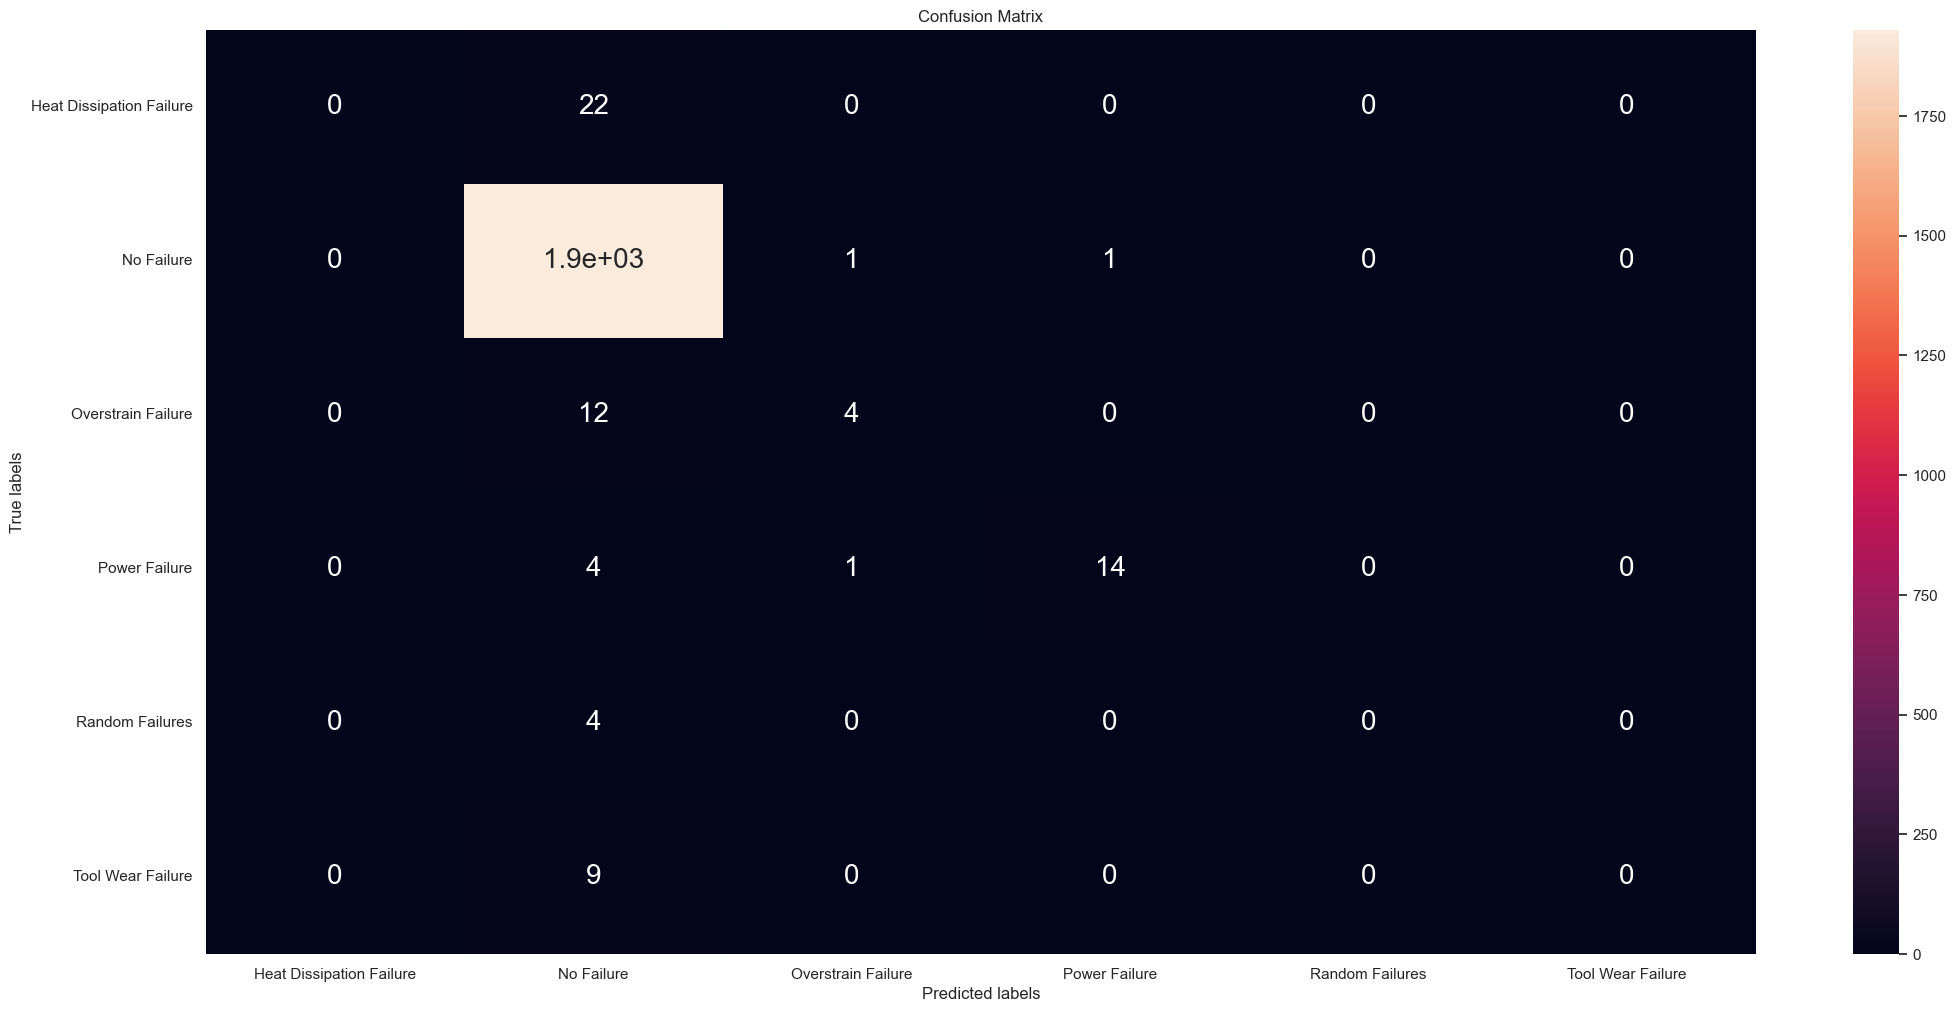

In [15]:
confusion_m(y_val,yhat_lr)

## 7.2 KNN

In [16]:
#model
knn_model = KNeighborsClassifier(n_neighbors=3).fit(X_train,y_train)

# model training
yhat_knn = knn_model.predict(X_val)

#metrics
knn_metrics = mult_metrics('knn',y_val,yhat_knn)
knn_metrics

,mode_name,precison_multclass,recall_multclass,f1-score_multclass,balanced_score
0,knn,0.445606,0.379337,0.403994,0.379337


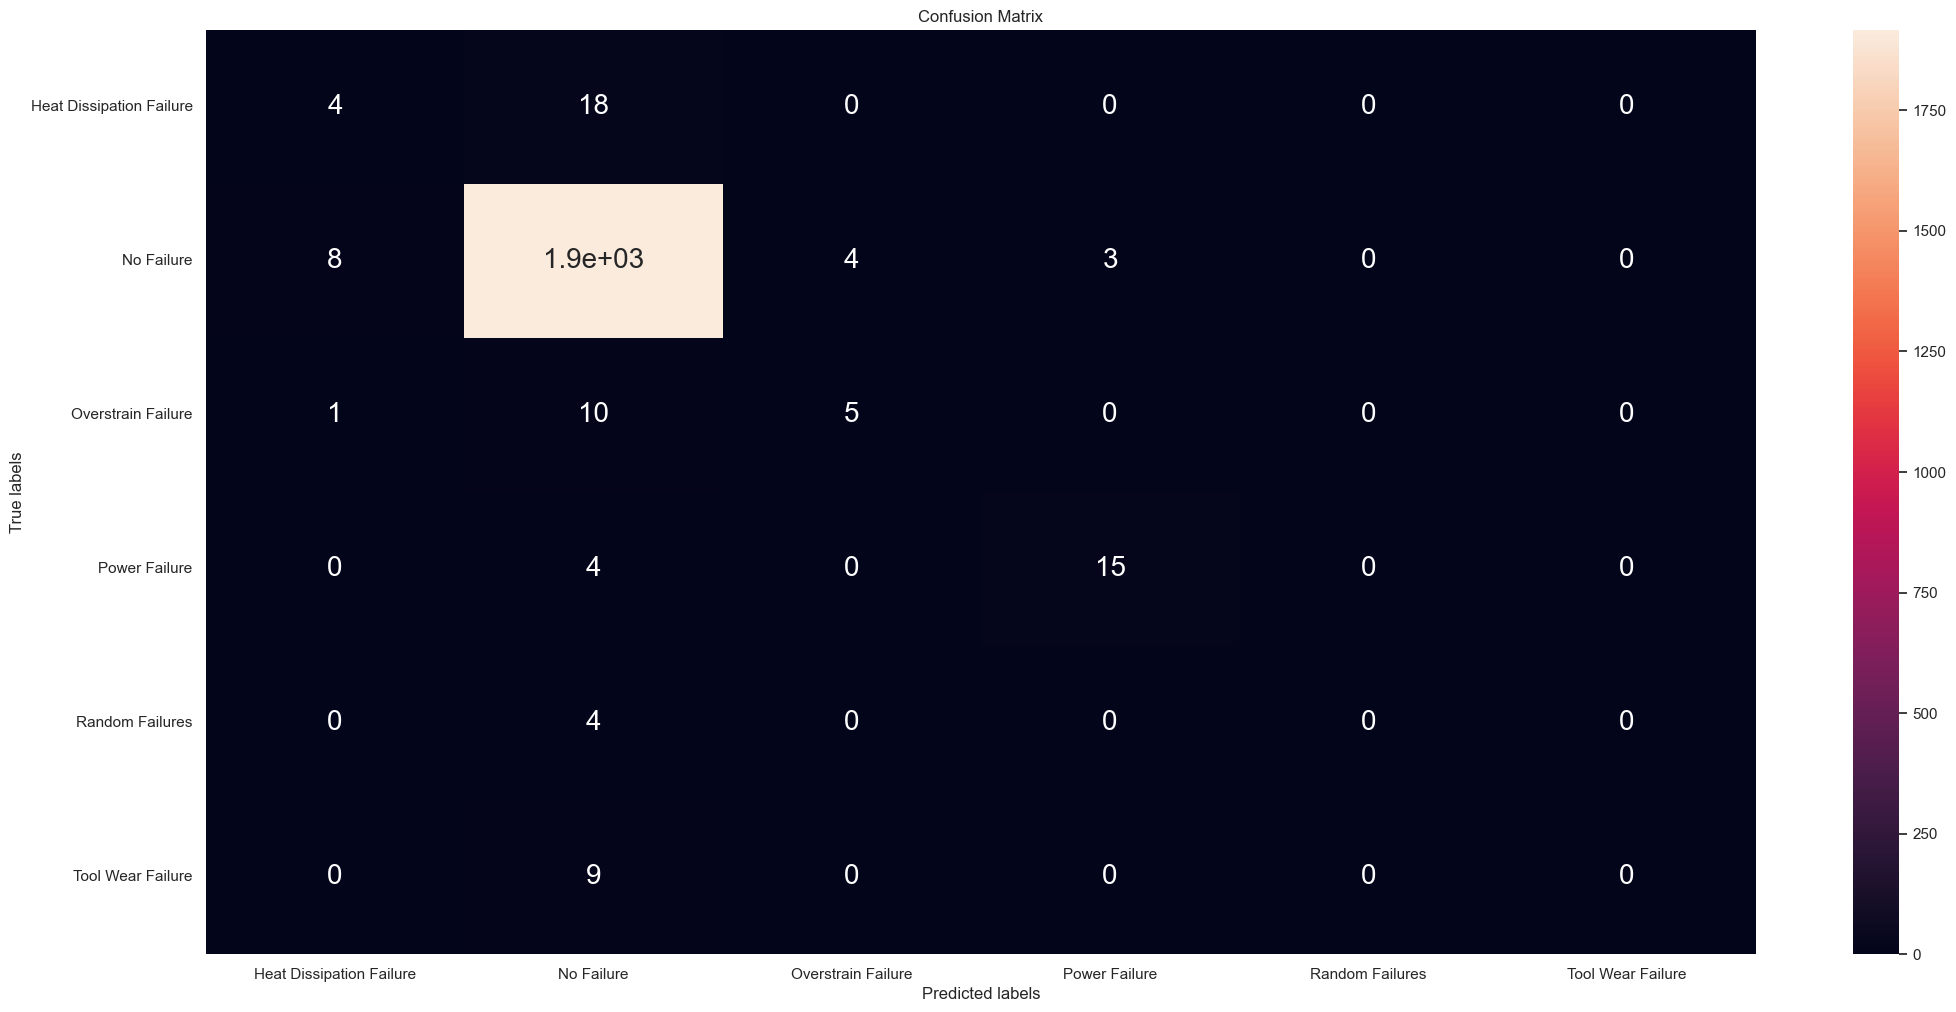

In [17]:
confusion_m(y_val,yhat_knn)

## 7.3 Random forrest 

In [18]:
#model training
rf_model = RandomForestClassifier(n_estimators=300,random_state=42,n_jobs=-1,class_weight='balanced').fit(X_train,y_train)

#model_predict
yhat_rf = rf_model.predict(X_val)

#metrics
rf_metrics= mult_metrics('random_forrest',y_val,yhat_rf)
rf_metrics

,mode_name,precison_multclass,recall_multclass,f1-score_multclass,balanced_score
0,random_forrest,0.552161,0.429071,0.468753,0.429071


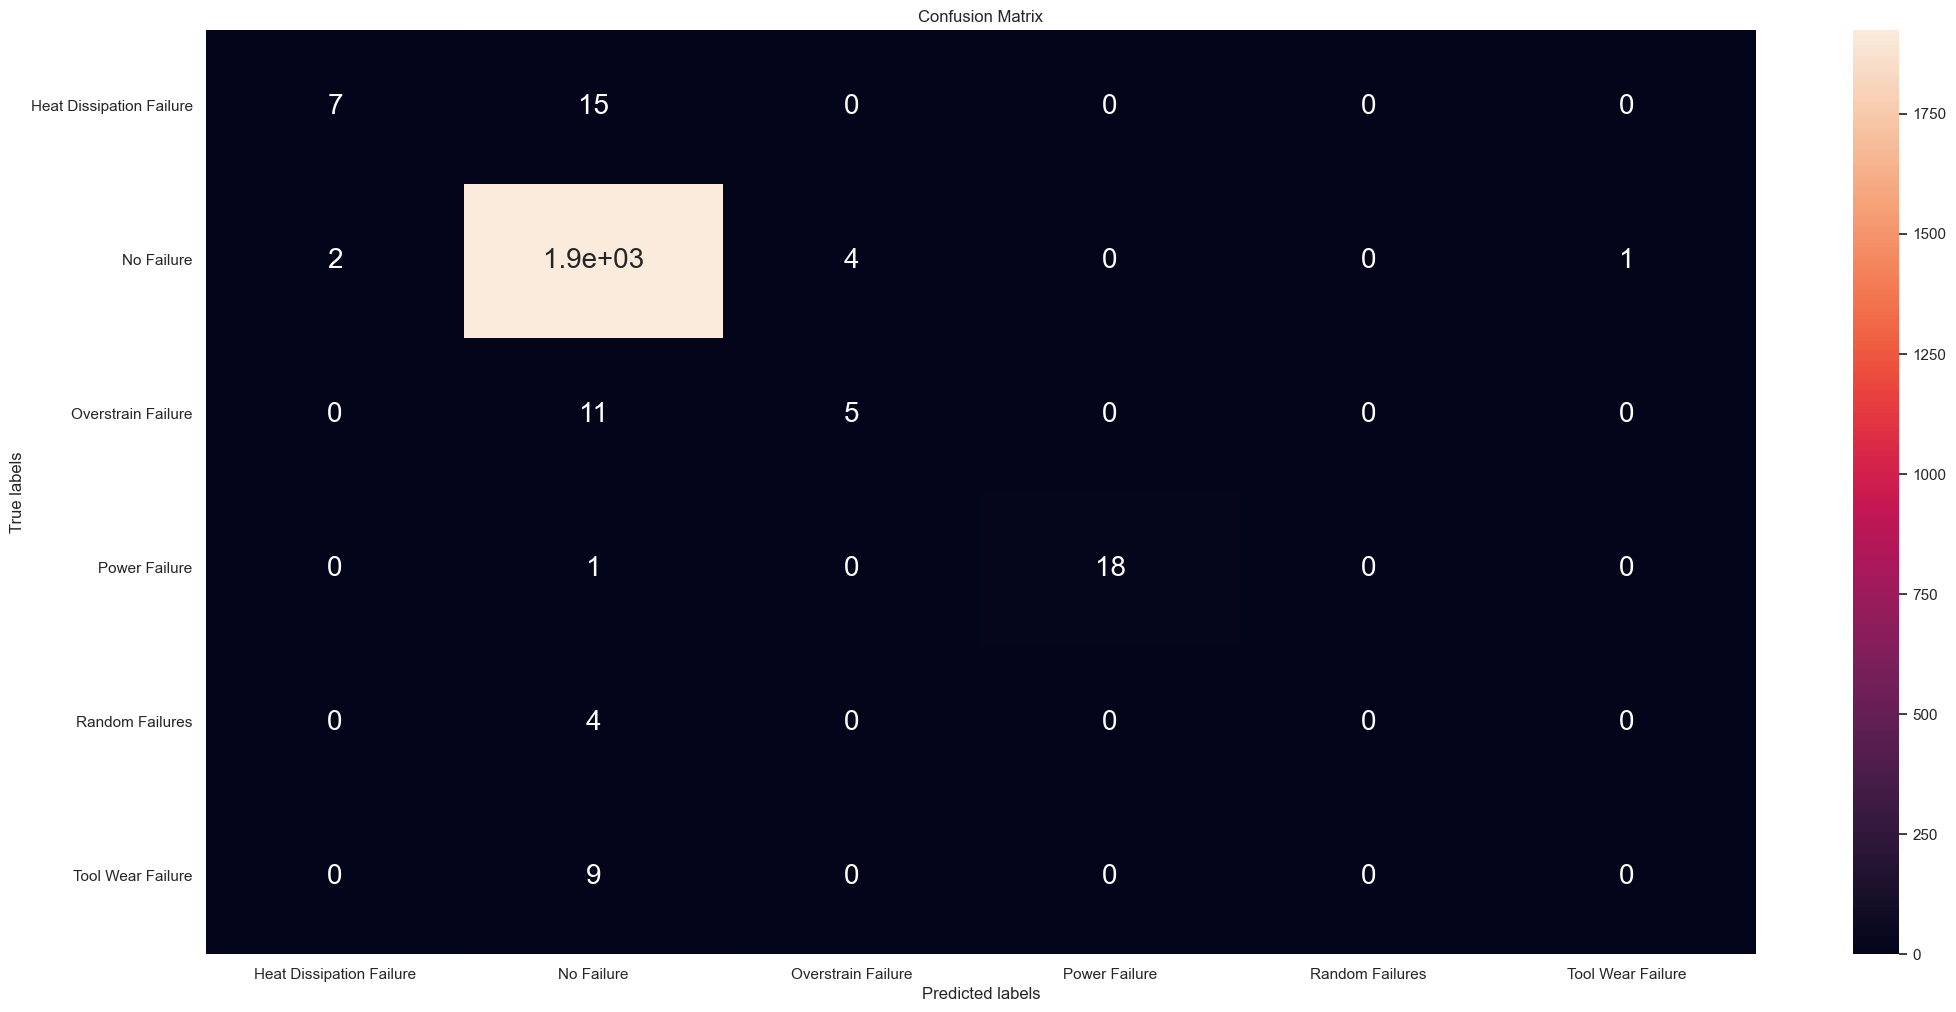

In [19]:
#confusion matrix
confusion_m(y_val,yhat_rf)

## 7.4 Extratree classifier

In [20]:
#model training
et_model = ExtraTreesClassifier(n_estimators=300,random_state=42,n_jobs=-1).fit(X_train,y_train)

#model predict
yhat_et = et_model.predict(X_val)

#metrics
et_metrics  = mult_metrics('extra_tree',y_val,yhat_et)
et_metrics 

,mode_name,precison_multclass,recall_multclass,f1-score_multclass,balanced_score
0,extra_tree,0.635009,0.380546,0.43876,0.380546


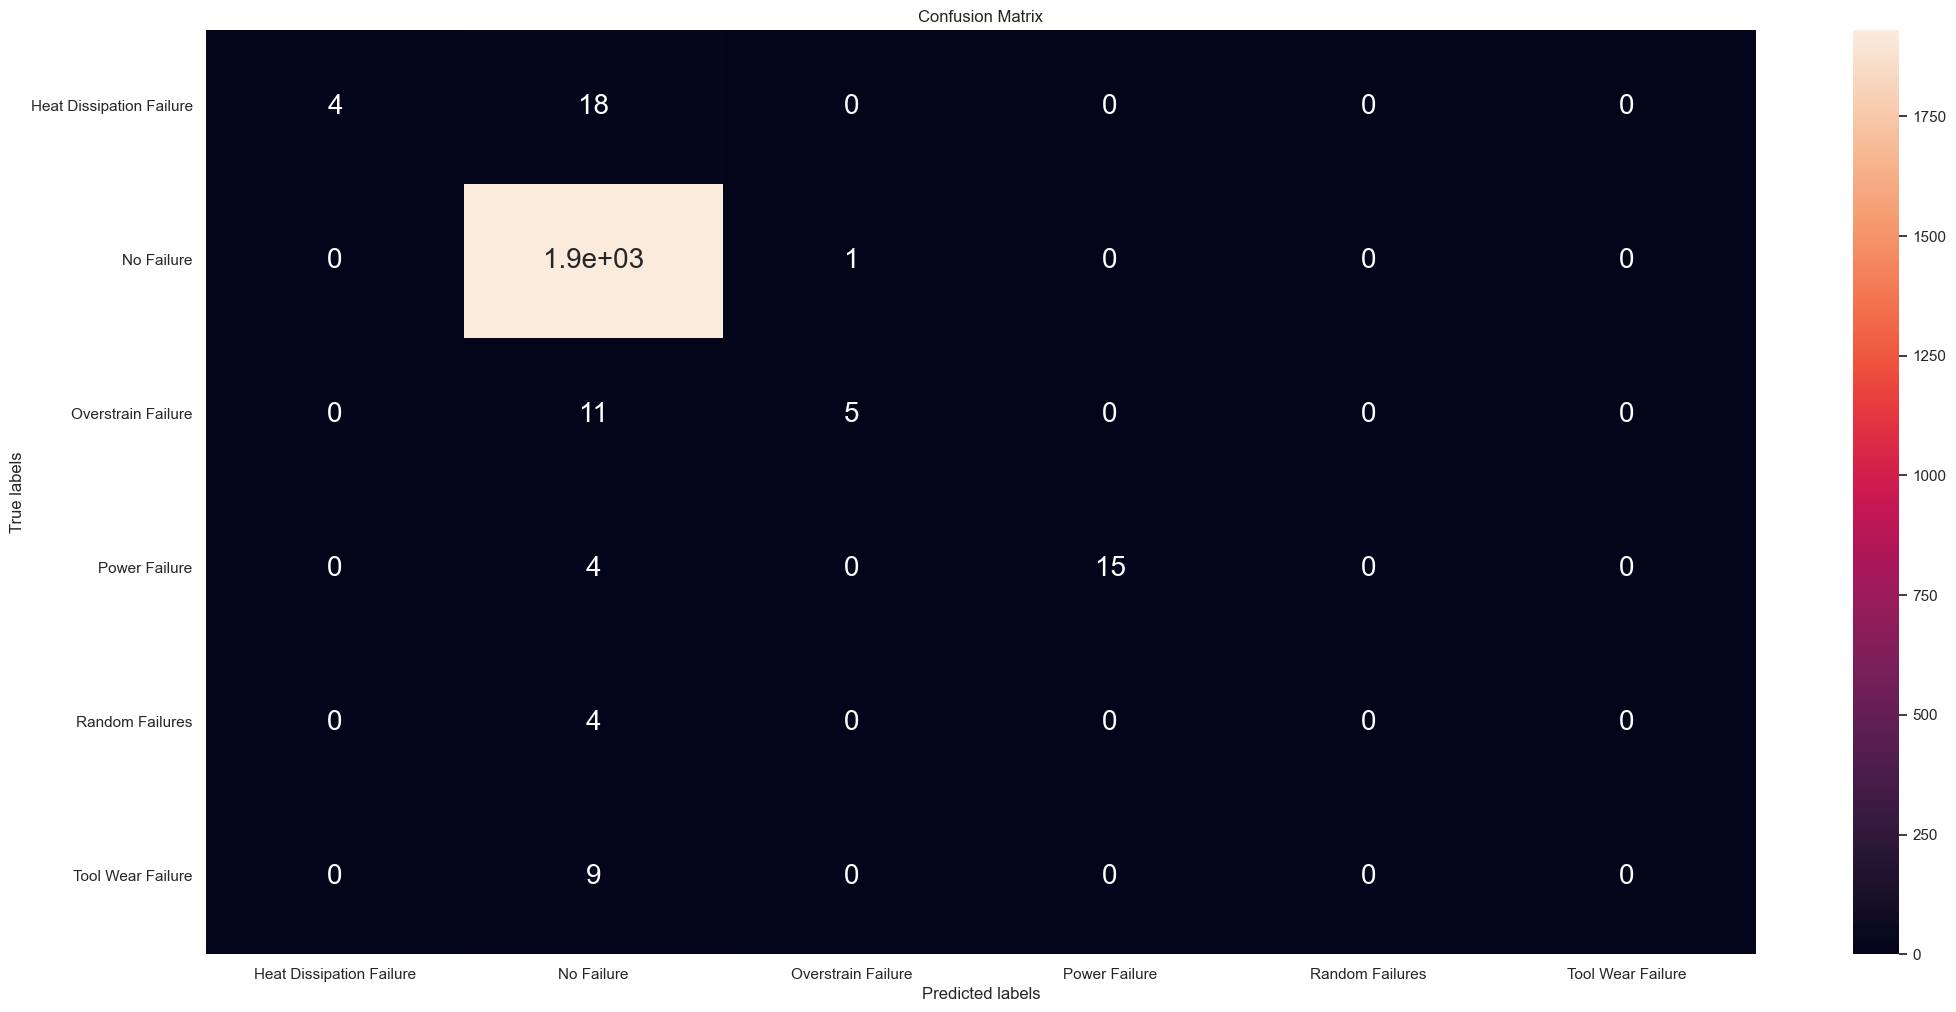

In [21]:
#confusion matrix
confusion_m(y_val,yhat_et)

## 7.5 Xgboost

In [22]:
#model
xgb_model = xgb.XGBClassifier(n_estimators=300,seed=42).fit(X_train,y_train)

#predict
yhat_xgb = xgb_model.predict(X_val)

#metrics
xgb_metrics = mult_metrics('xgboost',y_val,yhat_xgb)
xgb_metrics

,mode_name,precison_multclass,recall_multclass,f1-score_multclass,balanced_score
0,xgboost,0.570082,0.534261,0.550126,0.534261


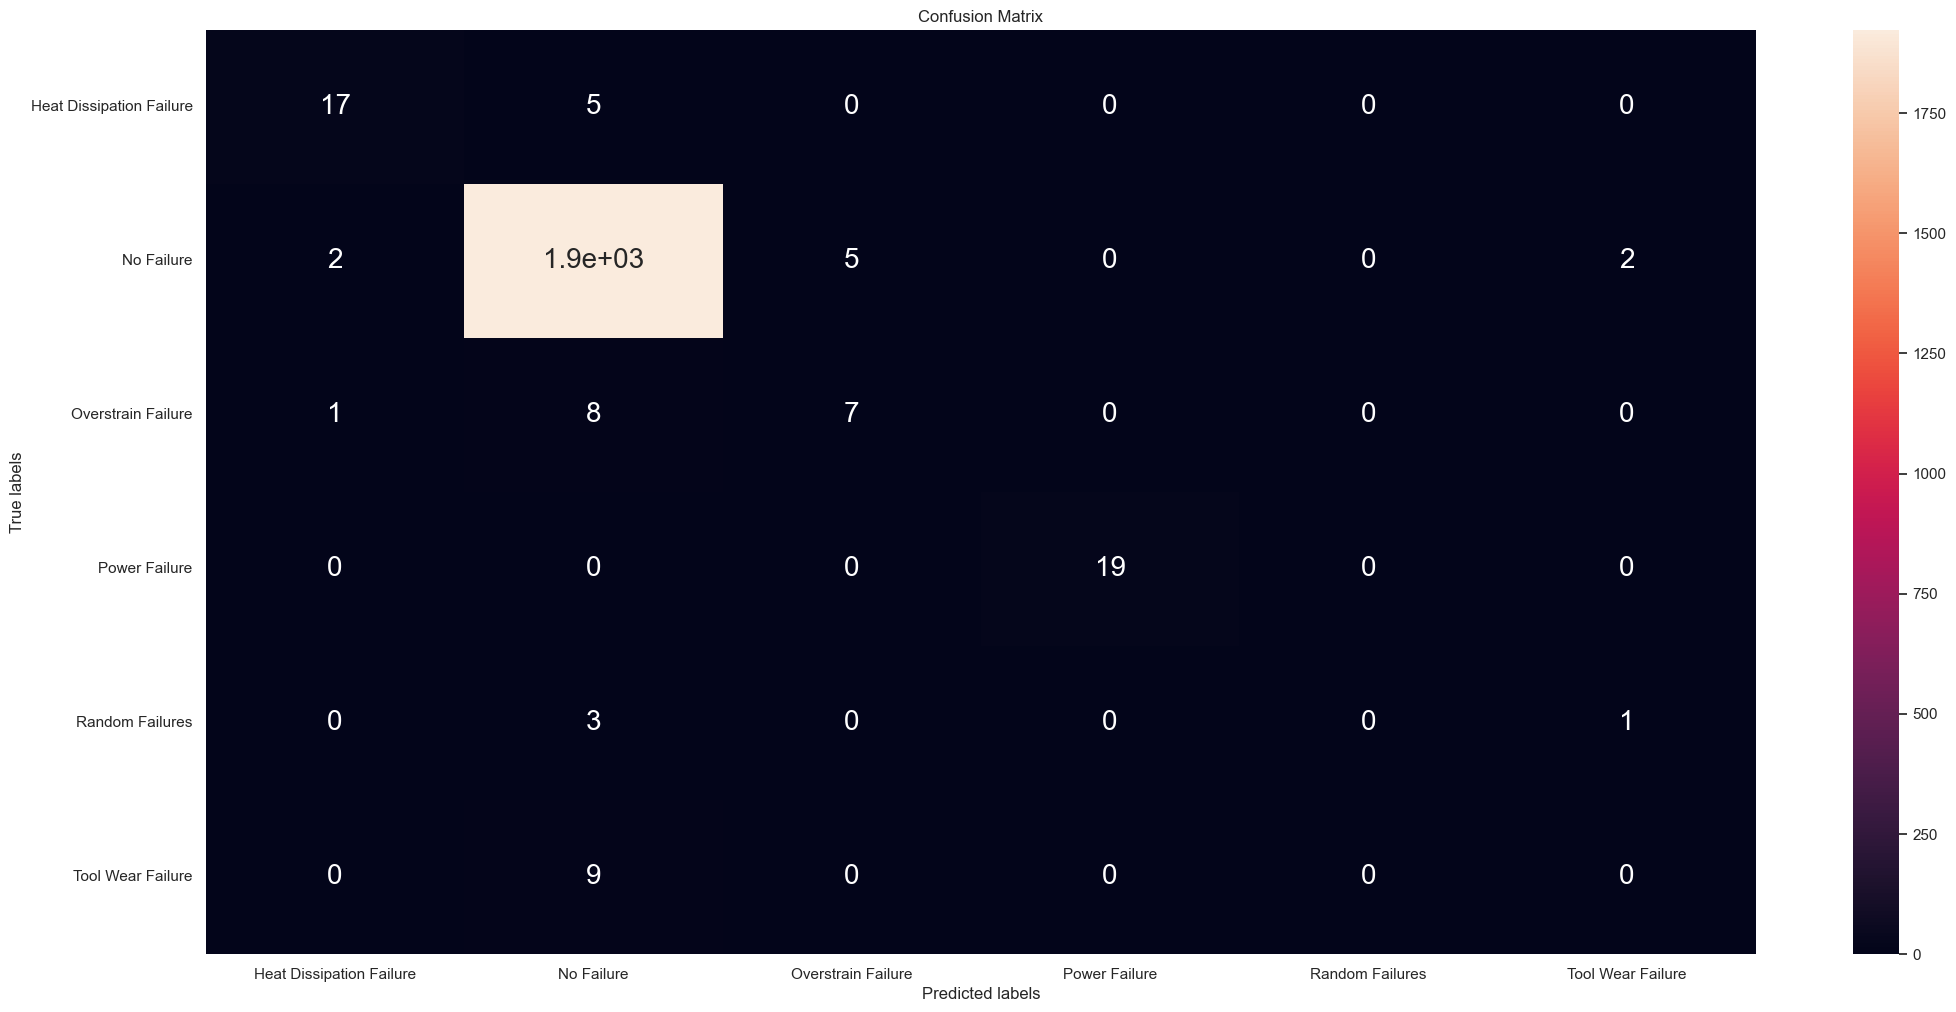

In [23]:
#confusion matrix
confusion_m(y_val,yhat_xgb)

##  7.6 lightgbm

In [24]:
#model
lgb_model = lgb.LGBMClassifier(n_estimators=300,seed=42).fit(X_train,y_train)

#predict
yhat_lgb = lgb_model.predict(X_val)

#metrics
lgb_metrics = mult_metrics('light',y_val,yhat_lgb)
lgb_metrics

,mode_name,precison_multclass,recall_multclass,f1-score_multclass,balanced_score
0,light,0.569746,0.537551,0.552454,0.537551


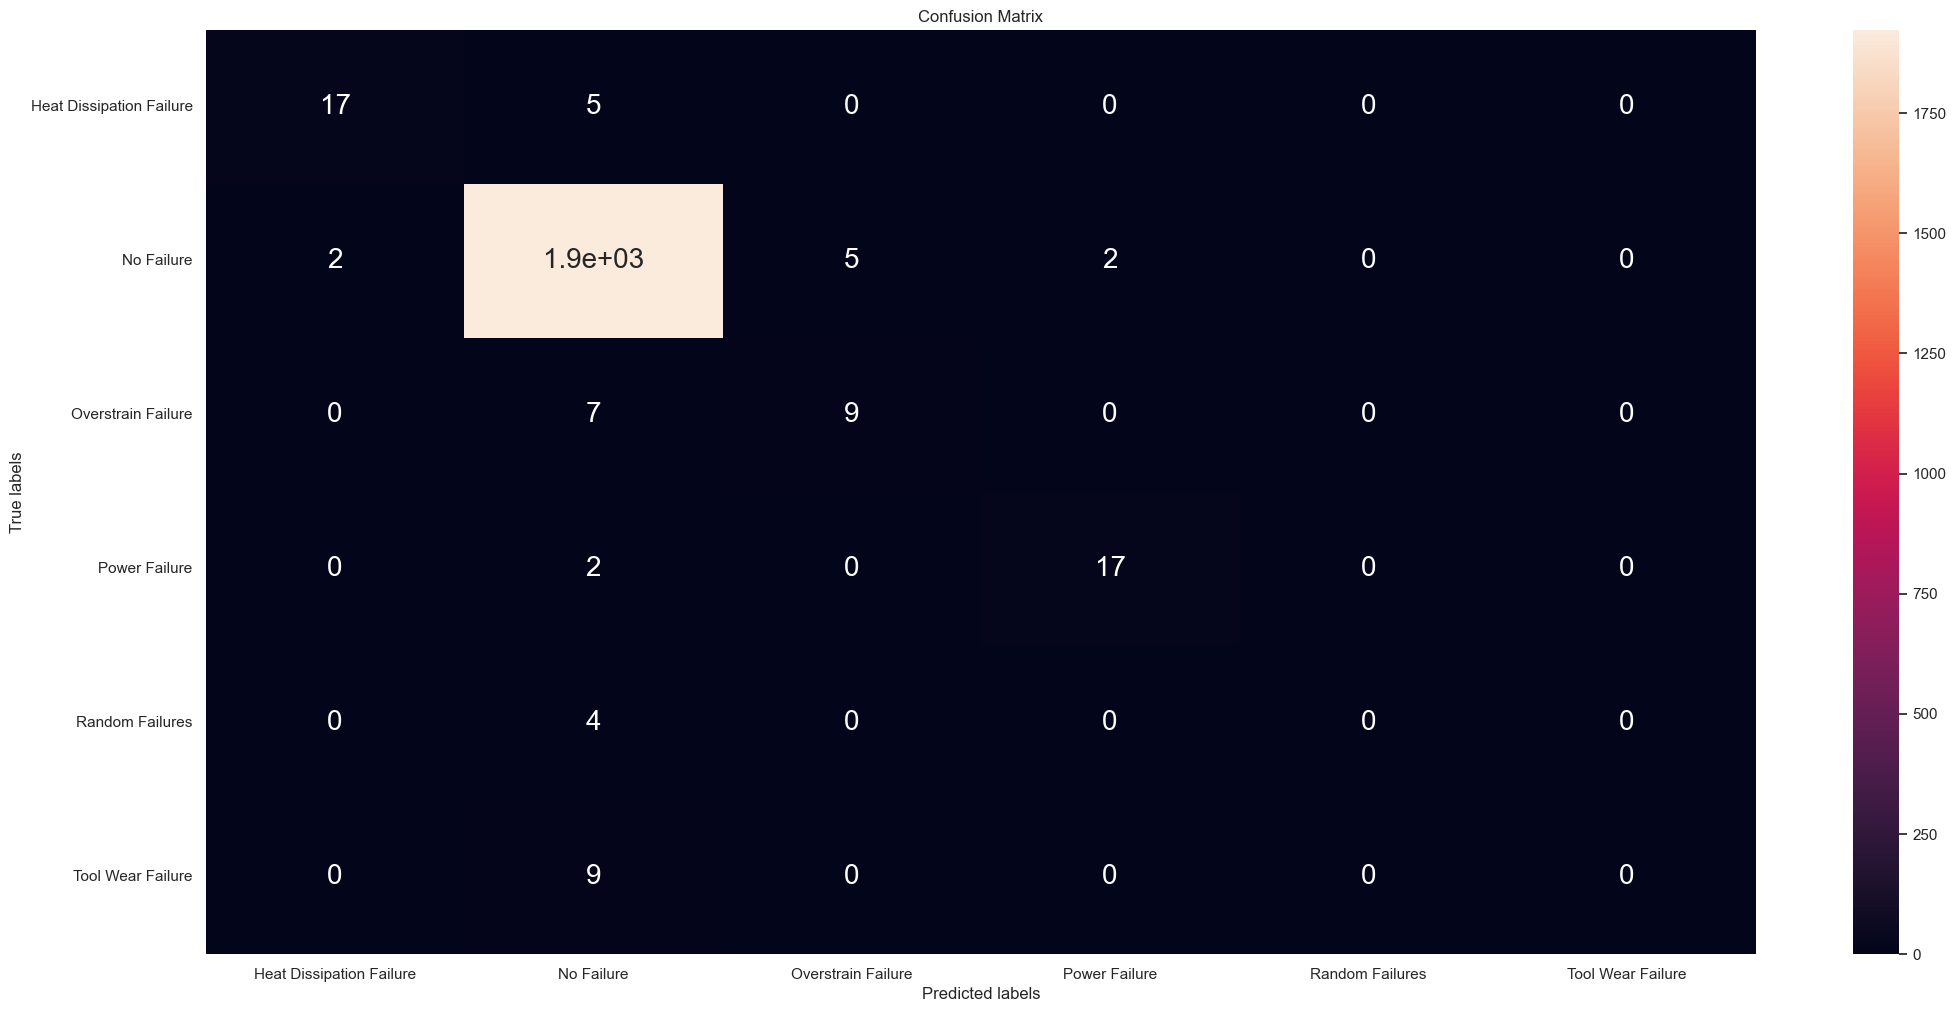

In [25]:
#confusion matrix
confusion_m(y_val,yhat_lgb)

## 7.7 Model comparison 

In [26]:
model_comp = pd.concat([knn_metrics,lr_metrics,rf_metrics,et_metrics,xgb_metrics,lgb_metrics])

In [27]:
model_comp.sort_values(by='recall_multclass',ascending=False)

,mode_name,precison_multclass,recall_multclass,f1-score_multclass,balanced_score
0,light,0.569746,0.537551,0.552454,0.537551
0,xgboost,0.570082,0.534261,0.550126,0.534261
0,random_forrest,0.552161,0.429071,0.468753,0.429071
0,extra_tree,0.635009,0.380546,0.438760,0.380546
0,knn,0.445606,0.379337,0.403994,0.379337
0,logistc_regression,0.429040,0.330968,0.362269,0.330968


## 7.7.1 Cross validation

In [28]:
models = {
    'KNN': knn_model,
    'Linear model': lr_model,
    'Random forrest': rf_model,
    'Extra trees': et_model,
    'XGBoost':xgb_model,
    'Lightgbm':lgb_model
}


In [29]:
models_comparison = pd.DataFrame()
for c, v in models.items():
    aux = performace_cross_val(df4,'failure_type',v,c)
    models_comparison = pd.concat([models_comparison,aux])

In [30]:
models_comparison.sort_values(by='recall_multclass_cv',ascending=False)

,Model name,precison_multclass_cv,precison_std,recall_multclass_cv,recall_cv,balanced_score_cv,balanced_std,f1_score_cv,f1_std
0,XGBoost Cross_Val,0.608,0.017,0.561,0.003,0.561,0.003,0.582,0.009
0,Lightgbm Cross_Val,0.597,0.035,0.554,0.018,0.554,0.018,0.570,0.024
0,Random forrest Cross_Val,0.602,0.038,0.469,0.026,0.469,0.026,0.517,0.030
0,KNN Cross_Val,0.469,0.034,0.372,0.029,0.372,0.029,0.406,0.023
0,Extra trees Cross_Val,0.555,0.078,0.372,0.013,0.372,0.013,0.415,0.020
0,Linear model Cross_Val,0.426,0.017,0.324,0.011,0.324,0.011,0.353,0.010


In [31]:
models_comparison = models_comparison.sort_values(by='recall_multclass_cv',ascending=False)
models_comparison.to_csv('model_table.csv')

# 8.0 Class weight balance machine learning models

**Agora iremos utilizar nos modelos os parametros refrêntes ao peso de cada classes. Assim os modelos darão menos peso para classe makoritária e mais peso para as classes minoritárias.**

In [32]:
sample_weights = class_weight.compute_sample_weight(class_weight='balanced',y=y_train)

In [33]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                classes = np.unique(y_train),
                                                y=y_train)
class_weights = dict(zip(np.unique(y_train),class_weights))

In [34]:
class_weights

{0: 14.672955974842766,
 1: 0.17266133806986383,
 2: 21.60185185185185,
 3: 17.674242424242426,
 4: 97.20833333333333,
 5: 37.03174603174603}

## 8.1 Linear regression

In [35]:
lr_model = lm.LogisticRegression(class_weight=class_weights).fit(X_train,y_train)

yhat_lr = lr_model.predict(X_val)

lr_metrics = mult_metrics('logistc_regression',y_val,yhat_lr)
lr_metrics

,mode_name,precison_multclass,recall_multclass,f1-score_multclass,balanced_score
0,logistc_regression,0.316005,0.762138,0.354767,0.762138


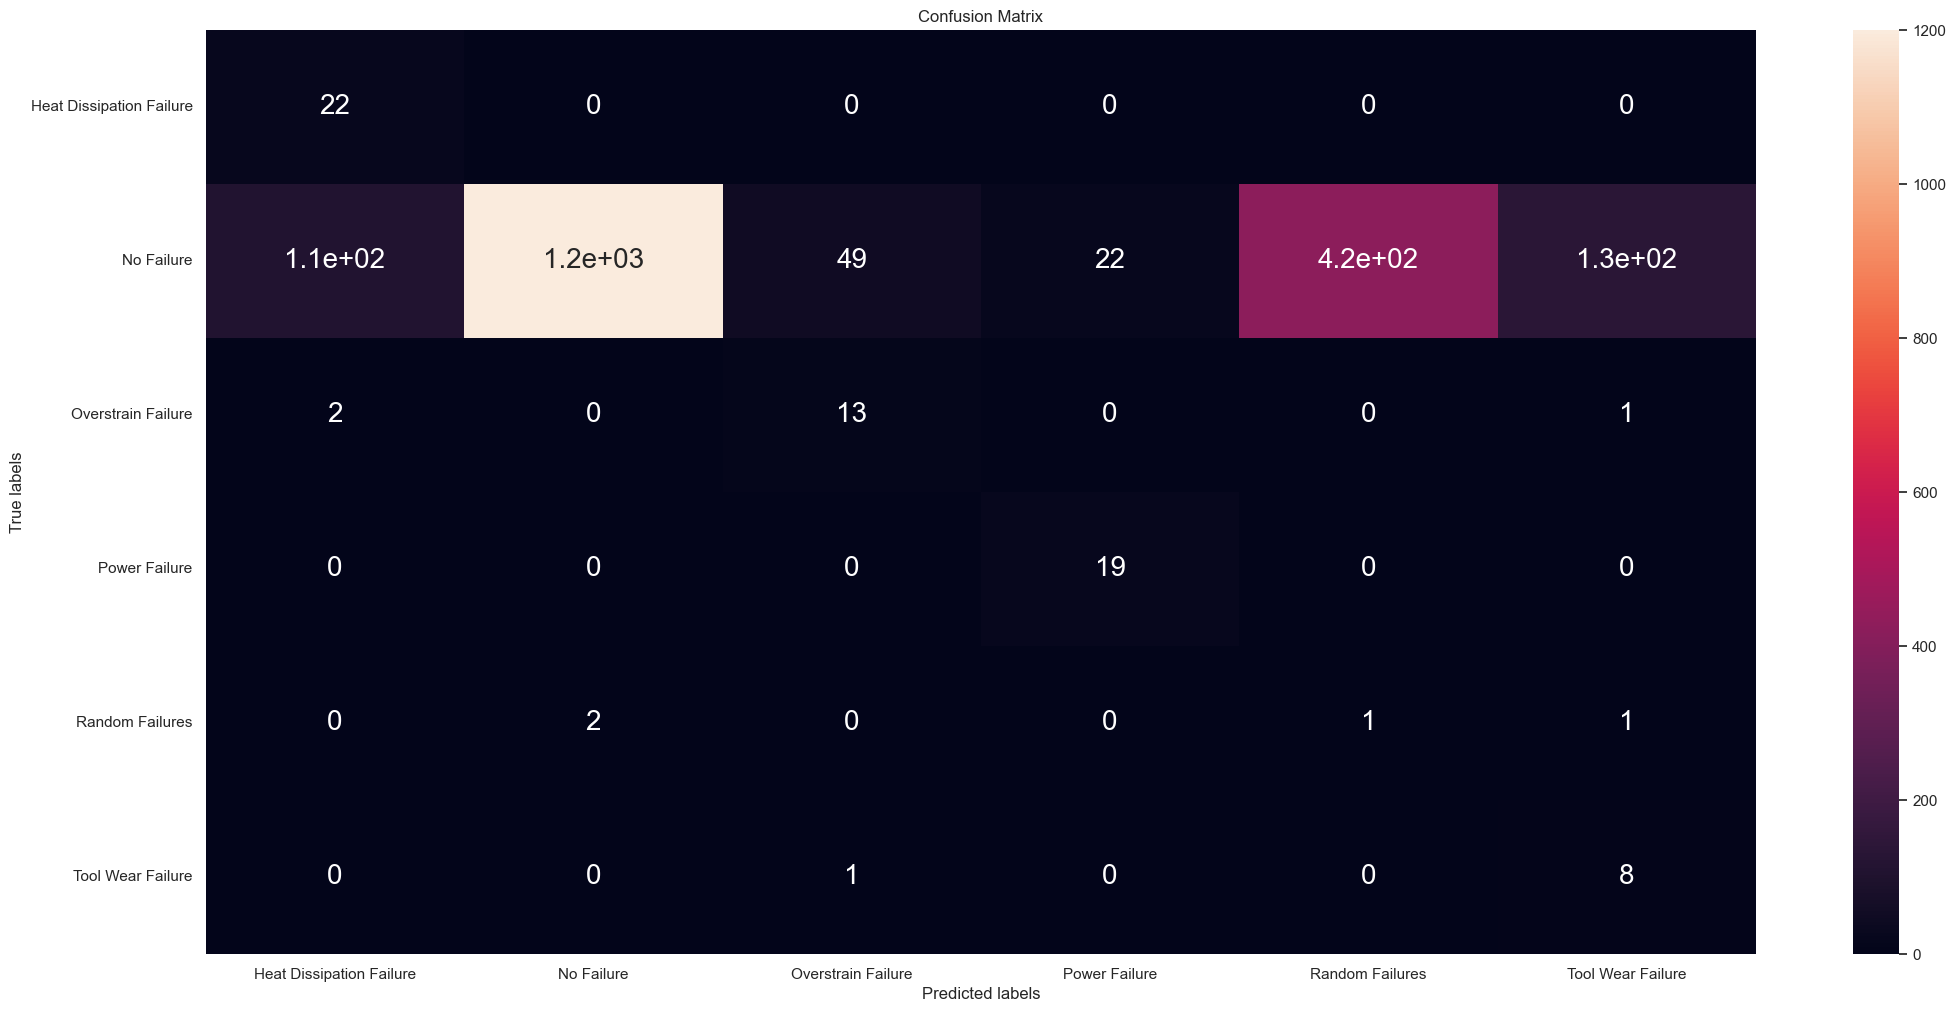

In [36]:
confusion_m(y_val,yhat_lr)

## 8.2 Random forrest 

In [37]:
#model training
rf_model = RandomForestClassifier(n_estimators=300,random_state=42,n_jobs=-1,class_weight='balanced_subsample').fit(X_train,y_train)

#model_predict
yhat_rf = rf_model.predict(X_val)

#metrics
rf_metrics= mult_metrics('random_forrest',y_val,yhat_rf)
rf_metrics

,mode_name,precison_multclass,recall_multclass,f1-score_multclass,balanced_score
0,random_forrest,0.554941,0.431998,0.470451,0.431998


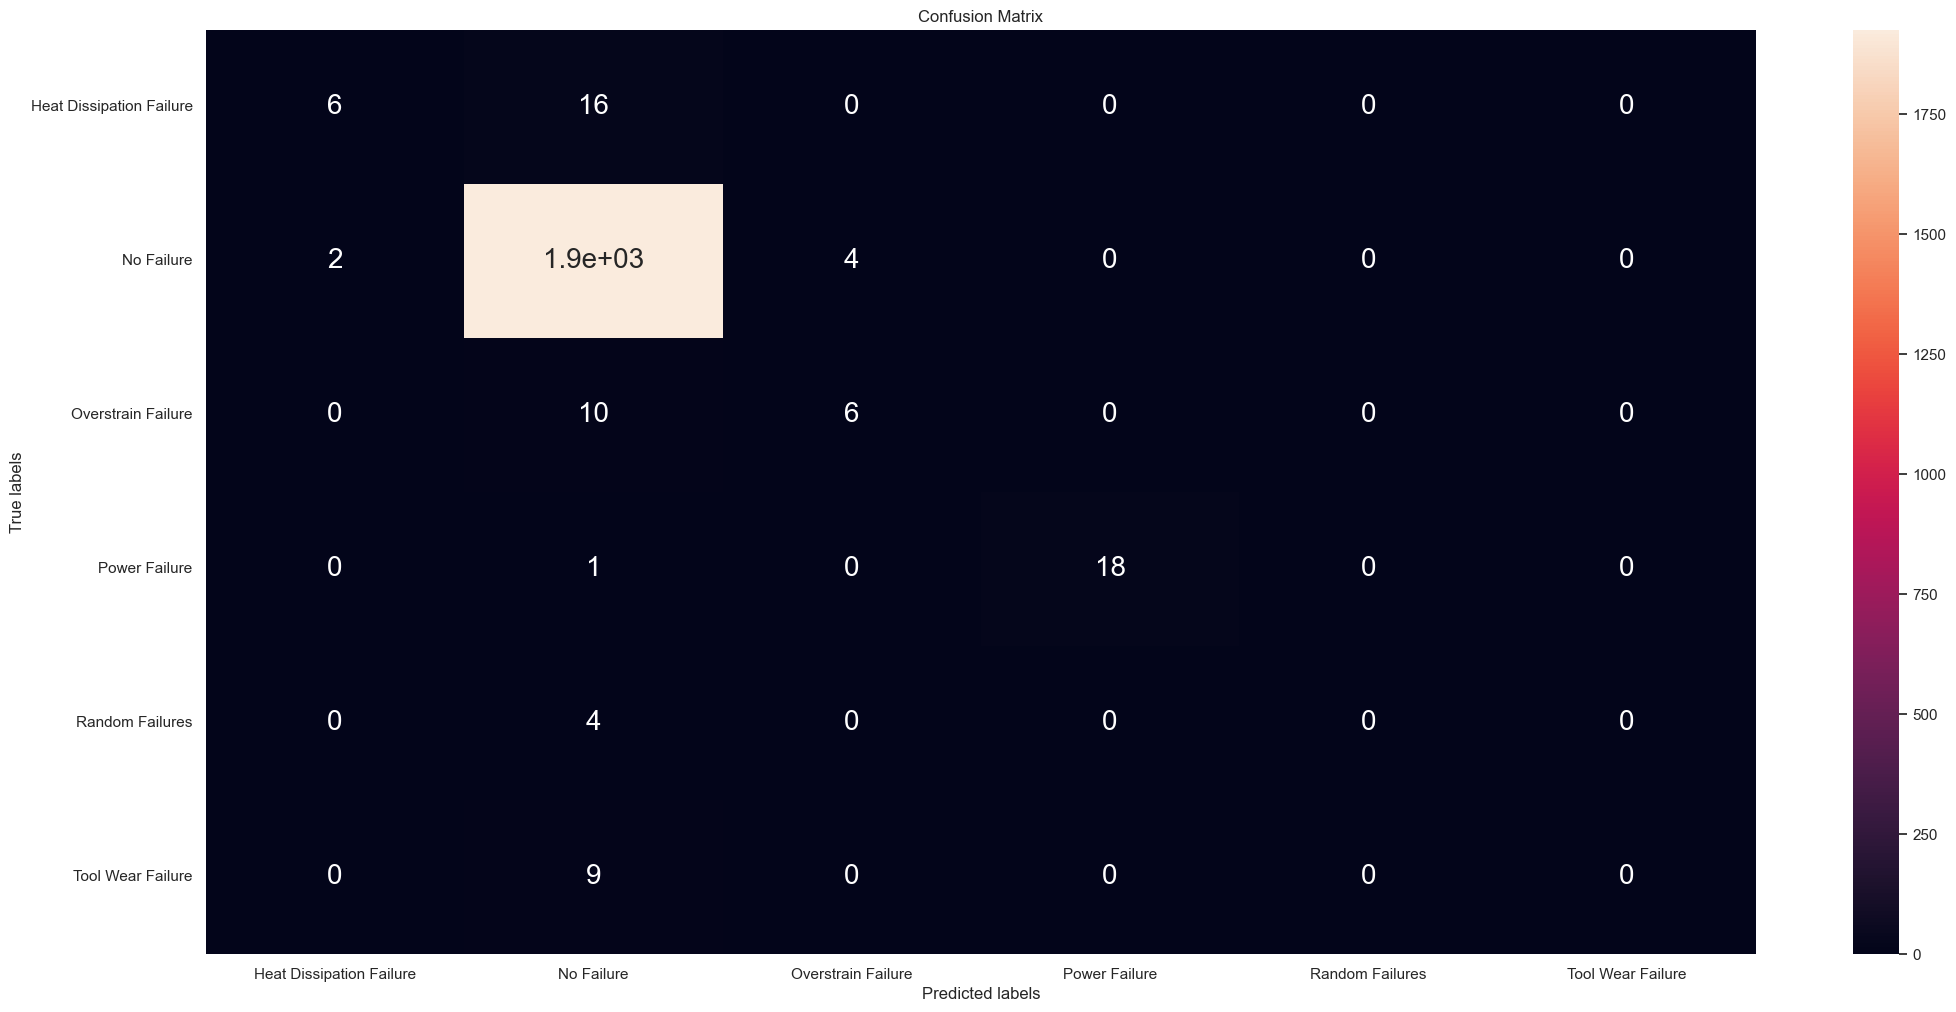

In [38]:
#confusion matrix
confusion_m(y_val,yhat_rf)

## 8.3 Balanced Random forrest 

In [39]:
#model training
brf_model = BalancedRandomForestClassifier(n_estimators=300,random_state=42,n_jobs=-1,class_weight='balanced_subsample').fit(X_train,y_train)

#model_predict
yhat_brf = brf_model.predict(X_val)

#metrics
brf_metrics= mult_metrics('balanced_rf',y_val,yhat_brf)
brf_metrics

,mode_name,precison_multclass,recall_multclass,f1-score_multclass,balanced_score
0,balanced_rf,0.306411,0.716402,0.324419,0.716402


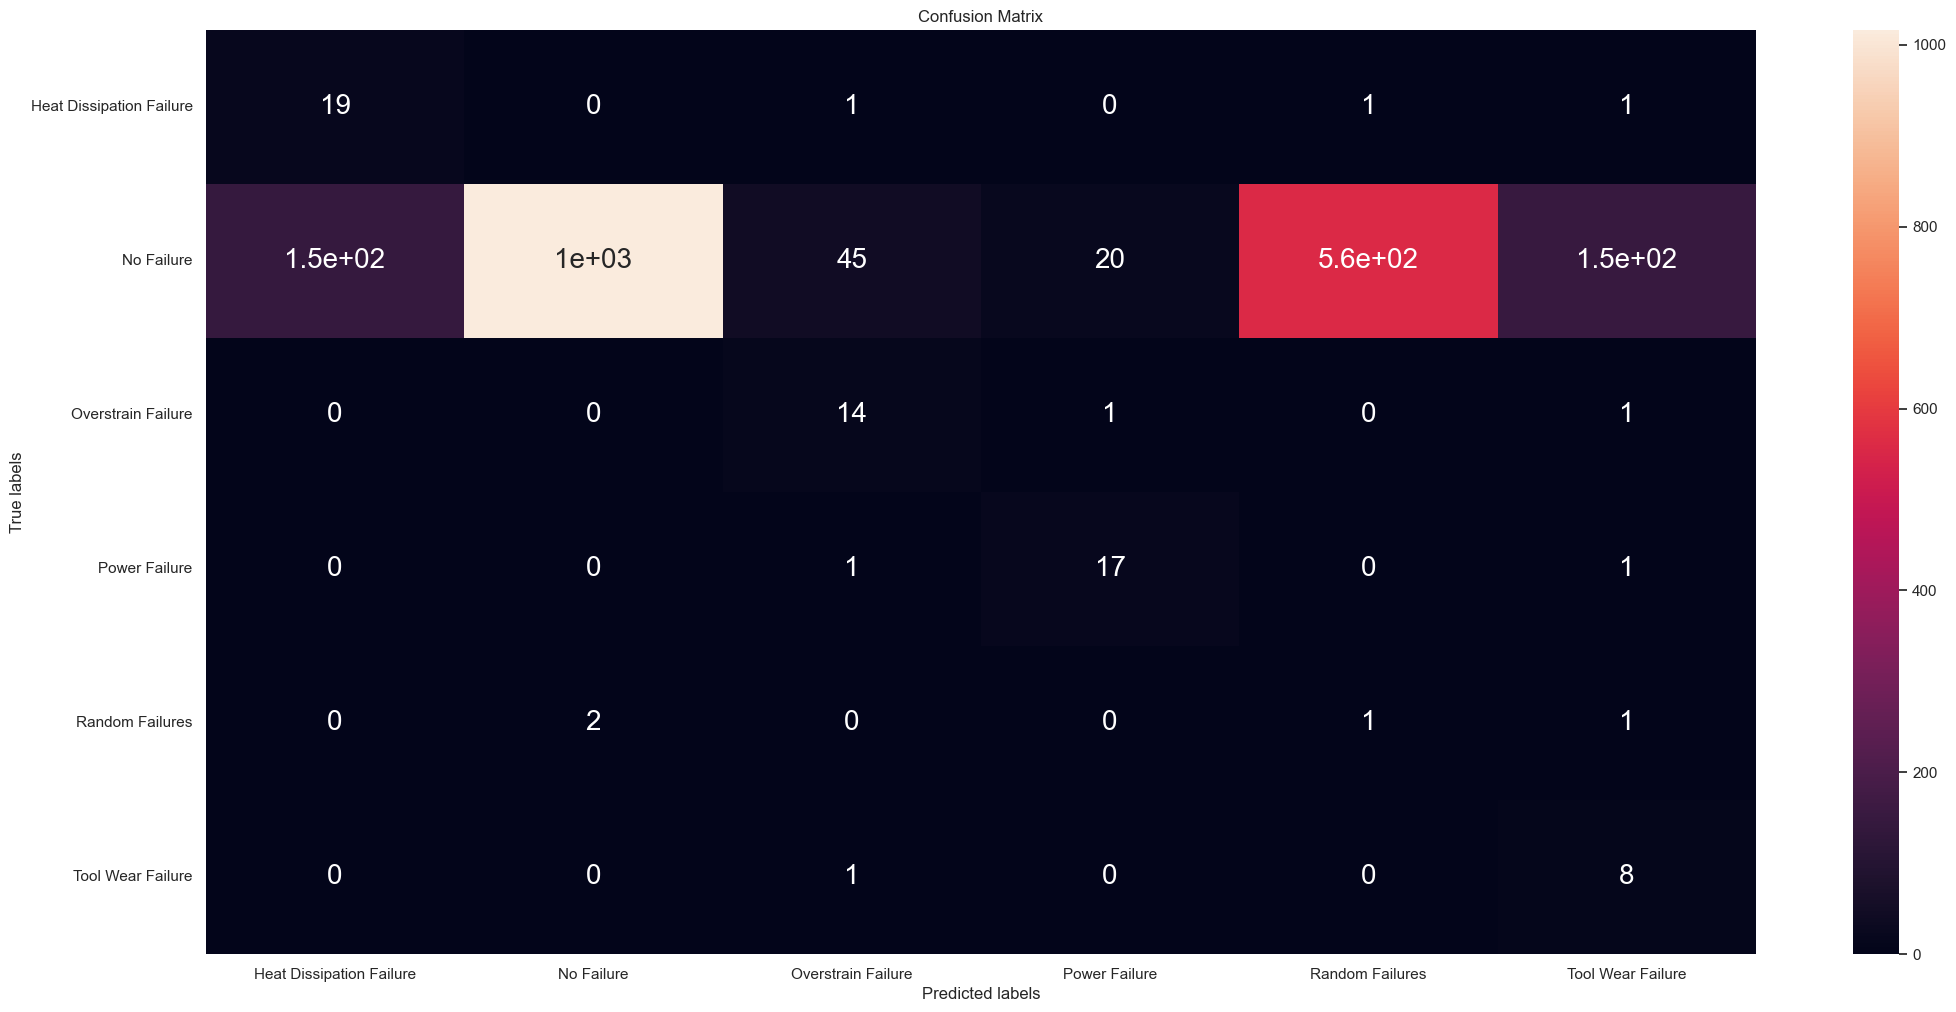

In [40]:
#confusion matrix
confusion_m(y_val,yhat_brf)

## 8.4 Extratree classifier

In [41]:
#model training
et_model = ExtraTreesClassifier(n_estimators=300,random_state=42,n_jobs=-1,class_weight='balanced_subsample').fit(X_train,y_train)

#model predict
yhat_et = et_model.predict(X_val)

#metrics
et_metrics  = mult_metrics('extra_tree',y_val,yhat_et)
et_metrics 

,mode_name,precison_multclass,recall_multclass,f1-score_multclass,balanced_score
0,extra_tree,0.570437,0.361098,0.407076,0.361098


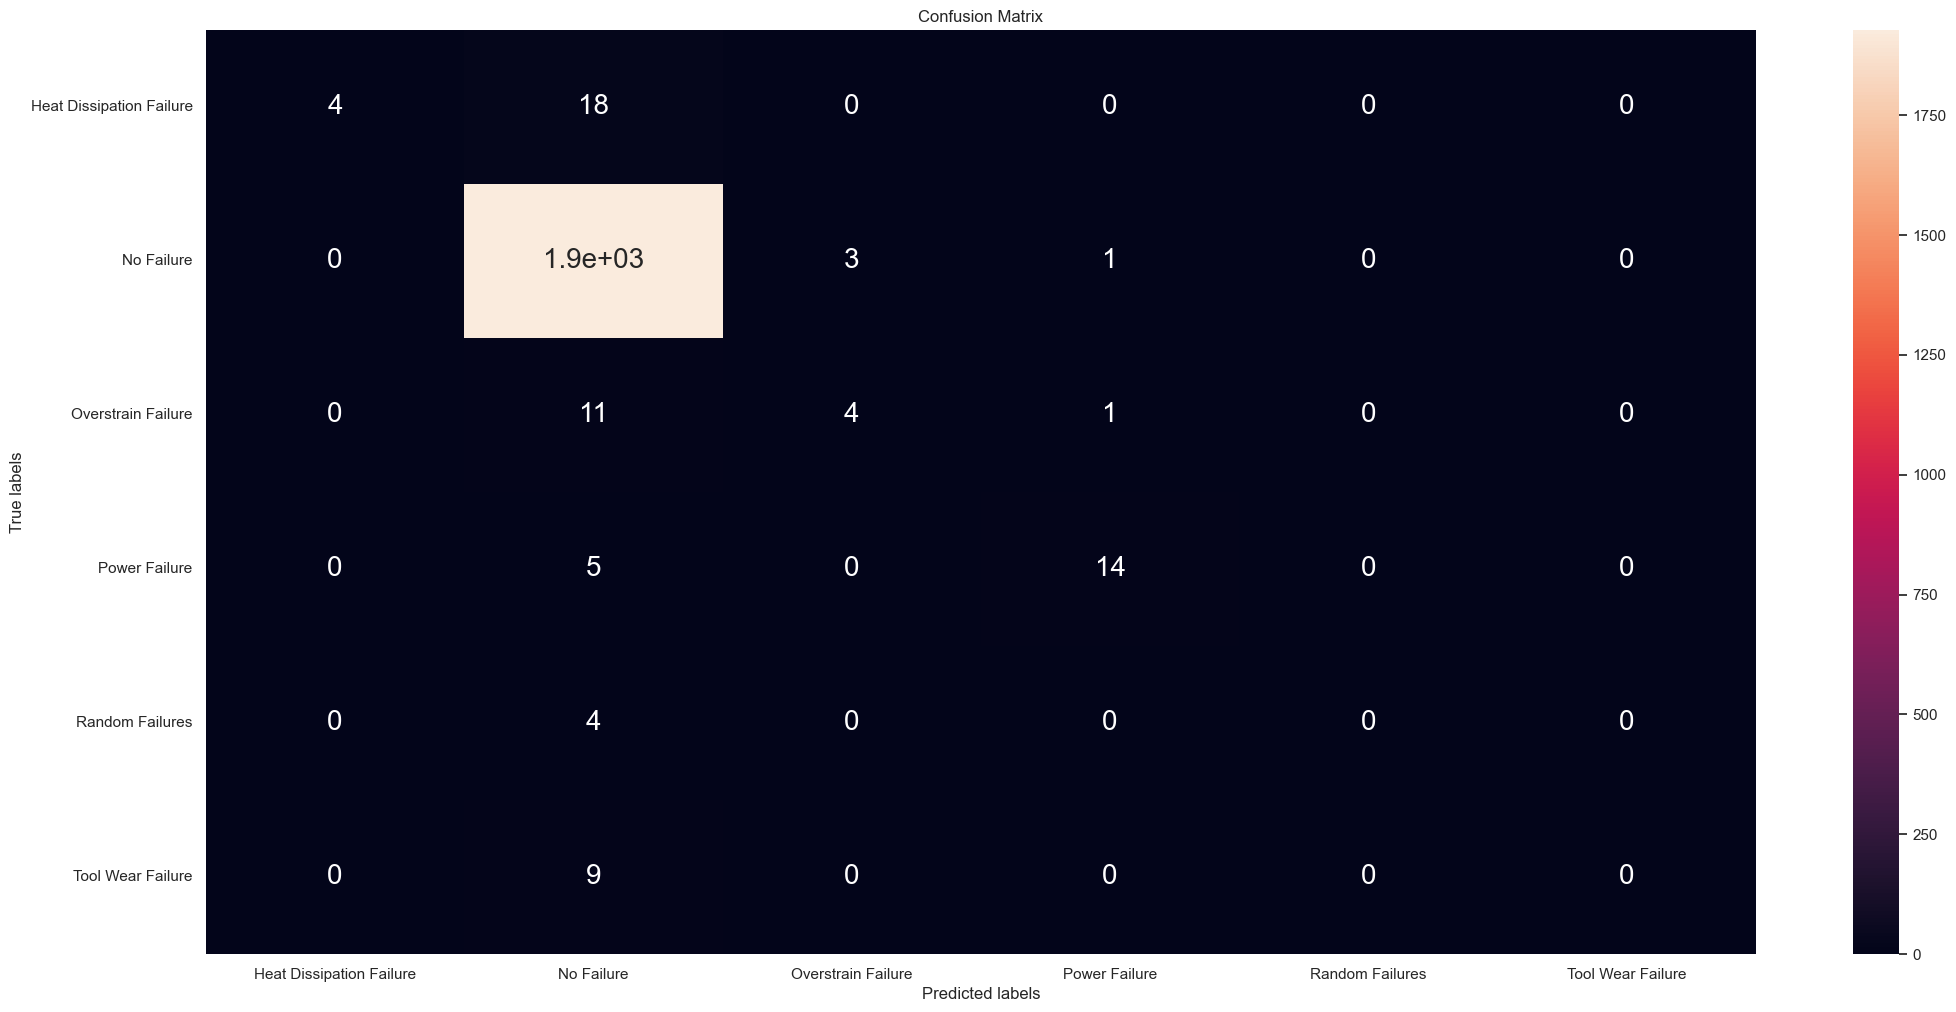

In [42]:
#confusion matrix
confusion_m(y_val,yhat_et)

## 8.5 XGboost

In [43]:
#model
xgb_model = xgb.XGBClassifier(n_estimators=300,seed=42).fit(X_train,y_train,sample_weight=sample_weights)

#predict
yhat_xgb = xgb_model.predict(X_val)

#metrics
xgb_metrics = mult_metrics('xgboost',y_val,yhat_xgb)
xgb_metrics

,mode_name,precison_multclass,recall_multclass,f1-score_multclass,balanced_score
0,xgboost,0.57614,0.587548,0.581151,0.587548


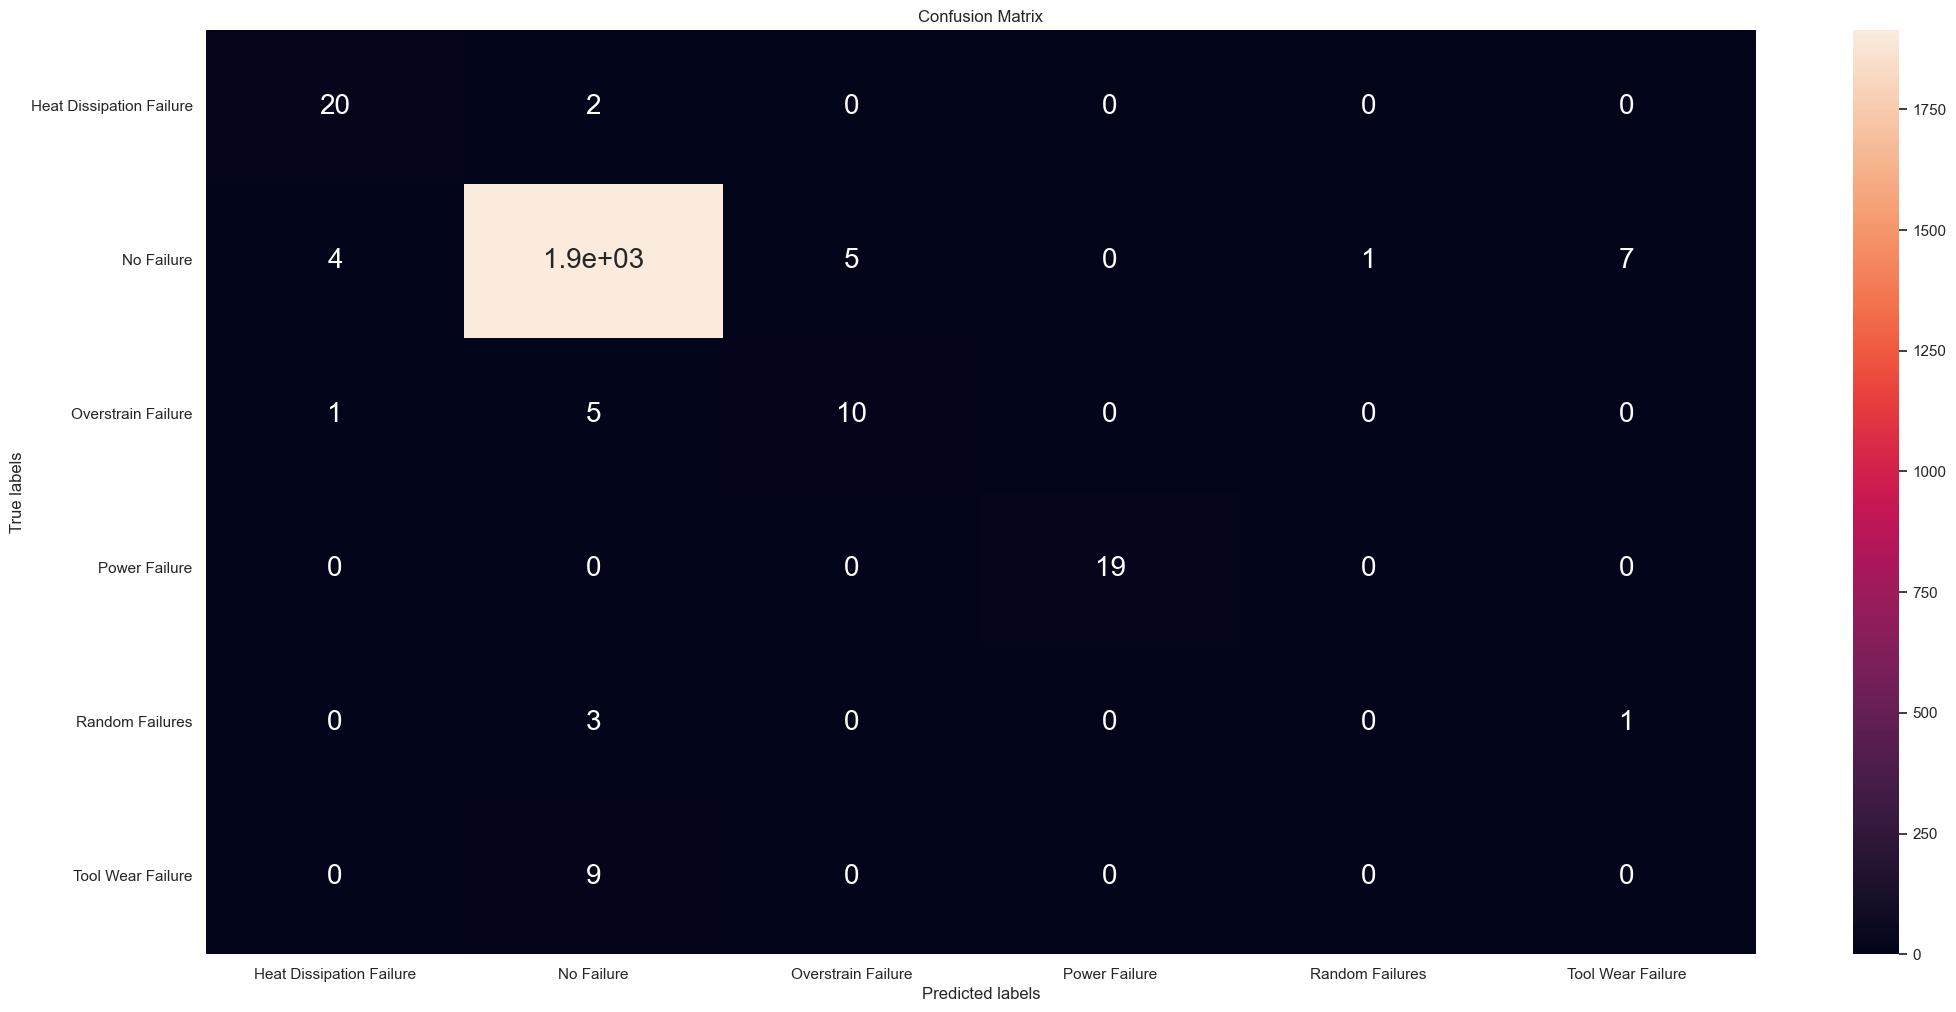

In [44]:
#confusion matrix
confusion_m(y_val,yhat_xgb)

## 8.6 lightgbm

In [45]:
#model
lgb_model = lgb.LGBMClassifier(n_estimators=300,seed=42).fit(X_train,y_train,sample_weight=sample_weights)

#predict
yhat_lgb = lgb_model.predict(X_val)

#metrics
lgb_metrics = mult_metrics('light',y_val,yhat_lgb)
lgb_metrics

,mode_name,precison_multclass,recall_multclass,f1-score_multclass,balanced_score
0,light,0.586348,0.555638,0.569908,0.555638


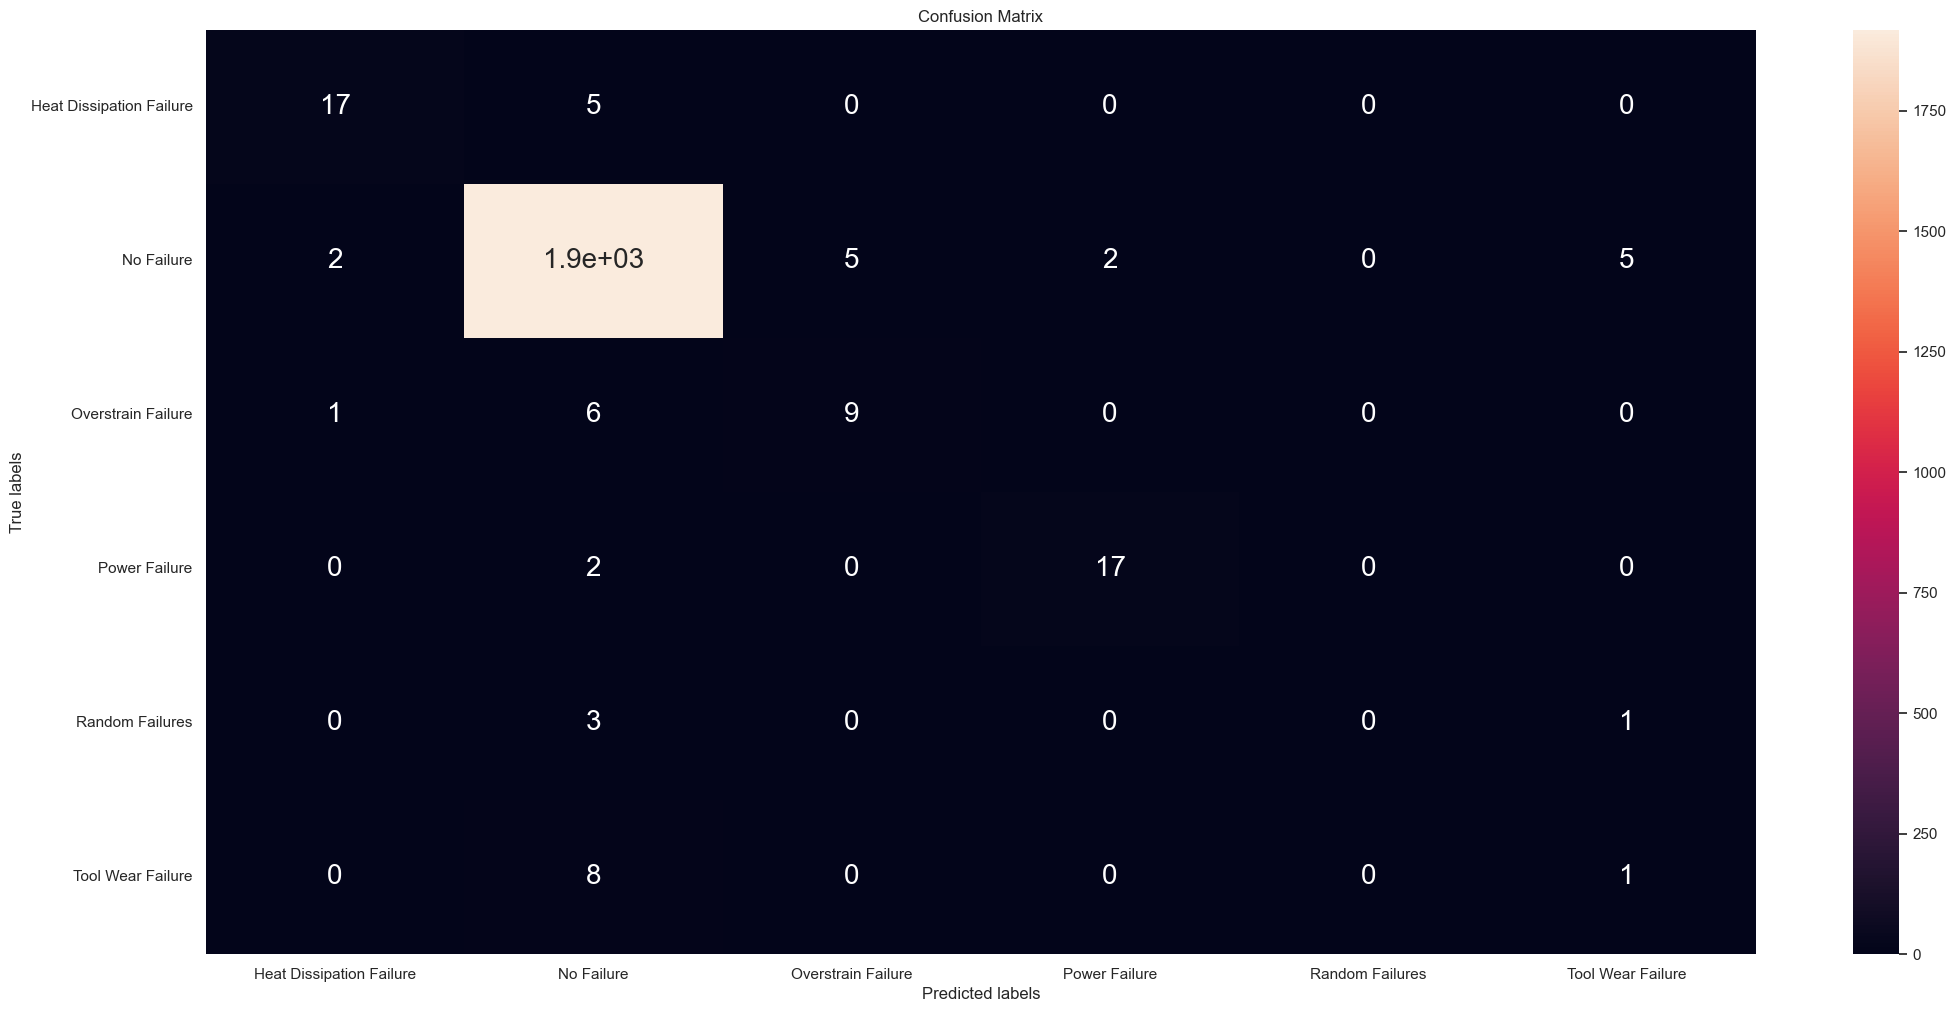

In [46]:
#confusion matrix
confusion_m(y_val,yhat_lgb)

## 8.7 Balanced comparison

In [47]:
model_comp = pd.concat([lr_metrics,rf_metrics,et_metrics,xgb_metrics,lgb_metrics,brf_metrics])

In [48]:
model_comp.sort_values(by='recall_multclass',ascending=False)

,mode_name,precison_multclass,recall_multclass,f1-score_multclass,balanced_score
0,logistc_regression,0.316005,0.762138,0.354767,0.762138
0,balanced_rf,0.306411,0.716402,0.324419,0.716402
0,xgboost,0.576140,0.587548,0.581151,0.587548
0,light,0.586348,0.555638,0.569908,0.555638
0,random_forrest,0.554941,0.431998,0.470451,0.431998
0,extra_tree,0.570437,0.361098,0.407076,0.361098


## 8.7.1 cross validation

In [49]:
#dicionários com os modelos dos modelos
models = {
    'Random forrest': rf_model,
    'Balanced_rf':brf_model,
    'Extra trees': et_model,
}

In [50]:
#criação do dataframe para compoaração
models_comparison = pd.DataFrame()

#aplicação dos cross validation
for c, v in models.items():
    aux = performace_cross_val(df4,'failure_type',v,c)
    models_comparison = pd.concat([models_comparison,aux])

In [51]:
models_comparison.sort_values(by='recall_multclass_cv',ascending=False)

,Model name,precison_multclass_cv,precison_std,recall_multclass_cv,recall_cv,balanced_score_cv,balanced_std,f1_score_cv,f1_std
0,Balanced_rf Cross_Val,0.294,0.014,0.703,0.054,0.703,0.054,0.305,0.033
0,Random forrest Cross_Val,0.596,0.032,0.471,0.022,0.471,0.022,0.516,0.026
0,Extra trees Cross_Val,0.630,0.033,0.355,0.013,0.355,0.013,0.400,0.008


In [52]:
#dicionários com os modelos dos modelos
models = {
    'XGBoost':xgb_model,
    'Lightgbm':lgb_model
}

In [53]:
#criação do dataframe para compoaração
models_comparison = pd.DataFrame()

#aplicação dos cross validation
for c, v in models.items():
    aux = performace_cross_val_boost(df4,'failure_type',v,c)
    models_comparison = pd.concat([models_comparison,aux])

In [54]:
models_comparison.sort_values(by='recall_multclass_cv',ascending=False)

,Model name,precison_multclass_cv,precison_std,recall_multclass_cv,recall_cv,balanced_score_cv,balanced_std,f1_score_cv,f1_std
0,XGBoost Cross_Val,0.589,0.009,0.597,0.012,0.597,0.012,0.591,0.007
0,Lightgbm Cross_Val,0.574,0.021,0.567,0.035,0.567,0.035,0.568,0.029
